Projeto Loteca model XGBoost

#Bibliotecas

In [2]:
import pandas as pd
import numpy as np
from textwrap import shorten
from collections import deque
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import os
import glob
import re

Dados 2006 até 2012

In [3]:
# --- ETAPA 1: CARREGAMENTO DOS ARQUIVOS (2006-2012) ---
anos = list(range(2006, 2021))  # 2006 até 2012

# Listas para armazenar todos os DataFrames
df_serie_a_list = []
df_serie_b_list = []
df_times_list = []
df_copa_brasil_list = []
df_libertadores_list = []
df_sudamericana_list = []

for ano in anos:
    print(f"\n📅 Carregando dados de {ano}...")
    
    # Caminhos dos arquivos para o ano atual
    caminho_serie_a = f'dados/brasileiraoA/brasileiraoA{ano}.csv'
    caminho_serie_b = f'dados/brasileiraoB/brasileiraoB{ano}.csv'
    caminho_times = f'dados/times/times{ano}.csv'
    caminho_copa_brasil = f'dados/copadobrasil/copadobrasil{ano}.csv'
    caminho_libertadores = f'dados/libertadores/libertadores{ano}.csv'
    caminho_sudamericana = f'dados/sudamericana/sudamericana{ano}.csv'
    
    try:
        # Carrega cada arquivo e adiciona coluna de ano
        df_a = pd.read_csv(caminho_serie_a)
        df_a['Ano'] = ano
        df_serie_a_list.append(df_a)
        
        df_b = pd.read_csv(caminho_serie_b)
        df_b['Ano'] = ano
        df_serie_b_list.append(df_b)
        
        df_t = pd.read_csv(caminho_times)
        df_t['Ano'] = ano
        df_times_list.append(df_t)
        
        df_cb = pd.read_csv(caminho_copa_brasil)
        df_cb['Ano'] = ano
        df_copa_brasil_list.append(df_cb)
        
        df_lib = pd.read_csv(caminho_libertadores)
        df_lib['Ano'] = ano
        df_libertadores_list.append(df_lib)
        
        df_sud = pd.read_csv(caminho_sudamericana)
        df_sud['Ano'] = ano
        df_sudamericana_list.append(df_sud)
        
        print(f"✅ Dados de {ano} carregados com sucesso!")
        
    except FileNotFoundError as e:
        print(f"⚠️ Aviso: Arquivo de {ano} não encontrado: {e.filename}")
        continue
    except Exception as e:
        print(f"⚠️ Aviso: Erro ao carregar dados de {ano}: {e}")
        continue

# Verifica se há dados carregados
if not df_serie_a_list:
    print("❌ Erro: Nenhum dado da Série A foi carregado!")
    exit()

# Concatena todos os DataFrames
try:
    df_serie_a = pd.concat(df_serie_a_list, ignore_index=True)
    df_serie_b = pd.concat(df_serie_b_list, ignore_index=True)
    df_times = pd.concat(df_times_list, ignore_index=True)
    df_copa_brasil = pd.concat(df_copa_brasil_list, ignore_index=True)
    df_libertadores = pd.concat(df_libertadores_list, ignore_index=True)
    df_sudamericana = pd.concat(df_sudamericana_list, ignore_index=True)
    
    print("\n" + "="*50)
    print("✅ TODOS OS ARQUIVOS CSV CARREGADOS COM SUCESSO!")
    print("="*50)
    
    # Mostra estatísticas consolidada
    print(f"\n📊 ESTATÍSTICAS CONSOLIDADAS (2006-2012):")
    print(f"Número de registros Série A: {len(df_serie_a)}")
    print(f"Número de registros Série B: {len(df_serie_b)}")
    print(f"Número de registros Times: {len(df_times)}")
    print(f"Número de registros Copa do Brasil: {len(df_copa_brasil)}")
    print(f"Número de registros Libertadores: {len(df_libertadores)}")
    print(f"Número de registros Sudamericana: {len(df_sudamericana)}")
    
    # Distribuição por ano
    print(f"\n📅 DISTRIBUIÇÃO POR ANO:")
    print("Série A:")
    print(df_serie_a['Ano'].value_counts().sort_index())
    print("\nSérie B:")
    print(df_serie_b['Ano'].value_counts().sort_index())
    
except Exception as e:
    print(f"❌ Erro ao concatenar DataFrames: {e}")
    exit()

# --- ETAPA 2: PROCESSAMENTO DOS DADOS DE COPA ---
# --- FUNÇÃO PARA PROCESSAR JOGOS DE COPA ---
def processar_jogos_copa(df_copa, competicao):
    """Processa os jogos de copa e retorna um dicionário com informações por time"""
    jogos_por_time = {}
    
    # Verifica os nomes das colunas e ajusta conforme necessário
    coluna_mandante = None
    coluna_visitante = None
    coluna_data = None
    coluna_fase = None
    
    # Mapeia possíveis nomes de colunas
    possiveis_colunas = {
        'mandante': ['Time Mandante', 'Mandante', 'Time da Casa', 'Casa'],
        'visitante': ['Time Visitante', 'Visitante', 'Time de Fora', 'Fora'],
        'data': ['Data', 'Date', 'Dia'],
        'fase': ['Fase', 'Phase', 'Stage', 'Rodada']
    }
    
    for col in df_copa.columns:
        col_lower = col.lower()
        if any(x.lower() in col_lower for x in possiveis_colunas['mandante']):
            coluna_mandante = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['visitante']):
            coluna_visitante = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['data']):
            coluna_data = col
        elif any(x.lower() in col_lower for x in possiveis_colunas['fase']):
            coluna_fase = col
    
    if not all([coluna_mandante, coluna_visitante, coluna_data]):
        print(f"❌ Colunas não encontradas em {competicao}")
        return jogos_por_time
    
    for _, jogo in df_copa.iterrows():
        try:
            # Converte a data para formato datetime (tenta diferentes formatos)
            data_str = str(jogo[coluna_data])
            data_jogo = None
            
            # Tenta diferentes formatos de data
            formatos_data = ['%d/%m/%y', '%d/%m/%Y', '%Y-%m-%d', '%m/%d/%Y']
            for formato in formatos_data:
                try:
                    data_jogo = datetime.strptime(data_str, formato)
                    break
                except ValueError:
                    continue
            
            if data_jogo is None:
                continue
            
            # Adiciona informações para o time mandante
            mandante = str(jogo[coluna_mandante]).strip()
            if mandante and mandante != 'nan':
                if mandante not in jogos_por_time:
                    jogos_por_time[mandante] = []
                
                fase = str(jogo[coluna_fase]).strip() if coluna_fase else 'F'
                jogos_por_time[mandante].append({
                    'data': data_jogo,
                    'competicao': competicao,
                    'fase': fase,
                    'adversario': str(jogo[coluna_visitante]).strip(),
                    'local': 'casa'
                })
            
            # Adiciona informações para o time visitante
            visitante = str(jogo[coluna_visitante]).strip()
            if visitante and visitante != 'nan':
                if visitante not in jogos_por_time:
                    jogos_por_time[visitante] = []
                
                fase = str(jogo[coluna_fase]).strip() if coluna_fase else 'F'
                jogos_por_time[visitante].append({
                    'data': data_jogo,
                    'competicao': competicao,
                    'fase': fase,
                    'adversario': str(jogo[coluna_mandante]).strip(),
                    'local': 'fora'
                })
            
        except (ValueError, KeyError) as e:
            continue
    
    return jogos_por_time

# Processa os jogos de copa
jogos_copa_brasil = processar_jogos_copa(df_copa_brasil, 'Copa do Brasil')
jogos_libertadores = processar_jogos_copa(df_libertadores, 'Libertadores')
jogos_sudamericana = processar_jogos_copa(df_sudamericana, 'Sudamericana')
    
# Combina os dois dicionários
todos_jogos_copa = {}
for time in set(list(jogos_copa_brasil.keys()) + list(jogos_libertadores.keys()) + list(jogos_sudamericana.keys())):
    todos_jogos_copa[time] = (jogos_copa_brasil.get(time, []) + 
                             jogos_libertadores.get(time, []) + 
                             jogos_sudamericana.get(time, []))

# Ordena os jogos por data para cada time
for time in todos_jogos_copa:
    if todos_jogos_copa[time]:  # Verifica se há jogos
        todos_jogos_copa[time].sort(key=lambda x: x['data'])

def normalizar_times(nome):
    nome = str(nome).strip()
    substituicoes = {
        'Athletico-PR': 'Atlético-PR', 
        'Athletico Paranaense': 'Atlético-PR',
        'Ceará SC': 'Ceará', 
        'Sport Recife': 'Sport',
        'Vasco da Gama': 'Vasco', 
        'América Mineiro': 'América-MG',
        'Atlético Mineiro': 'Atlético-MG', 
        'Atlético Goianiense': 'Atlético-GO',
        'Red Bull Bragantino': 'Bragantino',
        'Grêmio Novorizontino': 'Novorizontino'
    }
    return substituicoes.get(nome, nome)



📅 Carregando dados de 2006...
✅ Dados de 2006 carregados com sucesso!

📅 Carregando dados de 2007...
✅ Dados de 2007 carregados com sucesso!

📅 Carregando dados de 2008...
✅ Dados de 2008 carregados com sucesso!

📅 Carregando dados de 2009...
✅ Dados de 2009 carregados com sucesso!

📅 Carregando dados de 2010...
✅ Dados de 2010 carregados com sucesso!

📅 Carregando dados de 2011...
✅ Dados de 2011 carregados com sucesso!

📅 Carregando dados de 2012...
✅ Dados de 2012 carregados com sucesso!

📅 Carregando dados de 2013...
✅ Dados de 2013 carregados com sucesso!

📅 Carregando dados de 2014...
✅ Dados de 2014 carregados com sucesso!

📅 Carregando dados de 2015...
✅ Dados de 2015 carregados com sucesso!

📅 Carregando dados de 2016...
✅ Dados de 2016 carregados com sucesso!

📅 Carregando dados de 2017...
✅ Dados de 2017 carregados com sucesso!

📅 Carregando dados de 2018...
✅ Dados de 2018 carregados com sucesso!

📅 Carregando dados de 2019...
✅ Dados de 2019 carregados com sucesso!

📅 Car

Carregar Simulação 2016


In [4]:
# --- FUNÇÃO AUXILIAR: Ordenação Natural (1, 2, 10 em vez de 1, 10, 2) ---
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# --- ETAPA 3: CARREGAMENTO DOS ARQUIVOS DE SIMULAÇÃO (2006-2012) ---
anos_simulacao = list(range(2006, 2021))
lista_dfs_simulacao = []

print("🚀 Iniciando consolidação dos arquivos de simulação...")

for ano in anos_simulacao:
    caminho_pasta = f'simulacao/{ano}/'
    
    # Verifica se a pasta do ano existe
    if not os.path.exists(caminho_pasta):
        print(f"⚠️ Pasta não encontrada: {caminho_pasta}. Pulando...")
        continue
        
    # Busca arquivos rodada*.csv e ordena corretamente
    arquivos_rodadas = sorted(glob.glob(os.path.join(caminho_pasta, 'rodada*.csv')), key=natural_sort_key)
    
    print(f"📅 Ano {ano}: Encontrados {len(arquivos_rodadas)} arquivos de rodada.")
    
    for arquivo in arquivos_rodadas:
        try:
            df_temp = pd.read_csv(arquivo)
            
            # Adiciona o ano e extrai o número da rodada se não existir
            df_temp['Ano'] = ano
            if 'Rodada' not in df_temp.columns:
                # Extrai o número do nome do arquivo (ex: rodada5.csv -> 5)
                num_rodada = int(re.search(r'rodada(\d+)', arquivo).group(1))
                df_temp['Rodada'] = num_rodada
            
            lista_dfs_simulacao.append(df_temp)
        except Exception as e:
            print(f"⚠️ Erro ao ler {arquivo}: {e}")

# Concatenar todos os DataFrames de simulação
if lista_dfs_simulacao:
    df_simulacao_completo = pd.concat(lista_dfs_simulacao, ignore_index=True)
    
    # Ordenação lógica: primeiro por Ano, depois por Rodada e por fim pelo número do Jogo (1 a 14)
    df_simulacao_completo = df_simulacao_completo.sort_values(by=['Ano', 'Rodada', 'Jogo']).reset_index(drop=True)

    print("\n" + "="*50)
    print("✅ CONSOLIDAÇÃO DE SIMULAÇÃO CONCLUÍDA!")
    print("="*50)
    print(f"Total de rodadas carregadas: {len(lista_dfs_simulacao)}")
    print(f"Total de jogos (bilhetes): {len(df_simulacao_completo)}")
    
    # Exibe as primeiras linhas para conferência
    display(df_simulacao_completo.head(15))
else:
    print("❌ Erro: Nenhum arquivo de simulação foi carregado!")

🚀 Iniciando consolidação dos arquivos de simulação...
📅 Ano 2006: Encontrados 38 arquivos de rodada.
📅 Ano 2007: Encontrados 38 arquivos de rodada.
📅 Ano 2008: Encontrados 38 arquivos de rodada.
📅 Ano 2009: Encontrados 38 arquivos de rodada.
📅 Ano 2010: Encontrados 38 arquivos de rodada.
📅 Ano 2011: Encontrados 38 arquivos de rodada.
📅 Ano 2012: Encontrados 38 arquivos de rodada.
📅 Ano 2013: Encontrados 38 arquivos de rodada.
📅 Ano 2014: Encontrados 38 arquivos de rodada.
📅 Ano 2015: Encontrados 38 arquivos de rodada.
📅 Ano 2016: Encontrados 38 arquivos de rodada.
📅 Ano 2017: Encontrados 38 arquivos de rodada.
📅 Ano 2018: Encontrados 38 arquivos de rodada.
📅 Ano 2019: Encontrados 38 arquivos de rodada.
📅 Ano 2020: Encontrados 38 arquivos de rodada.

✅ CONSOLIDAÇÃO DE SIMULAÇÃO CONCLUÍDA!
Total de rodadas carregadas: 570
Total de jogos (bilhetes): 7980


,Jogo,Data,Time da Casa,Time Visitante,Serie,Rodada,Ano
0,1,14/04/06,Gama,Vila Nova,B,1,2006
1,2,14/04/06,Marília,Atlético-MG,B,1,2006
2,3,14/04/06,Avaí,Sport,B,1,2006
3,4,14/04/06,Guarani,CRB,B,1,2006
4,5,15/04/06,Juventude,Paraná,A,1,2006
5,6,15/04/06,Vasco,Internacional,A,1,2006
6,7,16/04/06,São Paulo,Flamengo,A,1,2006
7,8,16/04/06,Grêmio,Corinthians,A,1,2006
8,9,16/04/06,Botafogo,Fortaleza,A,1,2006
9,10,16/04/06,São Caetano,Cruzeiro,A,1,2006


Preparar Features

In [ ]:
# ============================================================================
# FUNÇÕES AUXILIARES
# ============================================================================

def extrair_gols(placar):
    """Extrai gols do placar no formato 'X-Y'."""
    try:
        gols = str(placar).replace('–', '-').split('-')
        return int(gols[0]), int(gols[1])
    except:
        return 0, 0

def calcular_momentum_ia(deque_resultados):
    """Calcula momentum ponderado dos últimos resultados (V/E/D)."""
    if not deque_resultados:
        return 0
    pontos_map = {'V': 3, 'E': 1, 'D': 0}
    vals = [pontos_map.get(res, 0) for res in deque_resultados]
    pesos = range(1, len(vals) + 1)
    return sum(v * p for v, p in zip(vals, pesos)) / sum(pesos)

def calcular_desespero(pos, rd):
    """Calcula nível de desespero baseado na posição e rodada."""
    if rd < 10:
        return 0
    urgencia = 0
    if pos <= 3:
        urgencia = 1.0  # Título
    elif pos <= 8:
        urgencia = 0.7  # Libertadores
    elif pos >= 17:
        urgencia = 1.2  # Rebaixamento
    elif pos >= 14:
        urgencia = 0.5  # Alerta
    return urgencia * (rd / 38)

def get_proxima_copa(time, data_atual):
    """Retorna código da próxima partida de copa (se houver)."""
    if 'todos_jogos_copa' in globals() and time in todos_jogos_copa:
        proximos = [j for j in todos_jogos_copa[time] if j['data'] > data_atual]
        if proximos:
            prox = min(proximos, key=lambda x: x['data'])
            if (prox['data'] - data_atual).days <= 7:
                return f"{prox['competicao'][0]}{prox['fase'][0]}"
    return '-'

def calcular_soberba(tem_copa, pos_time, pos_adv, rodada):
    """Calcula risco de soberba (poupar jogadores)."""
    if tem_copa == 0:
        return 0
    
    gap_tabela = pos_adv - pos_time
    if gap_tabela > 0:
        sinal = (gap_tabela / 20) ** 2
        return sinal * (rodada / 38)
    return 0

# ============================================================================
# FUNÇÃO PRINCIPAL
# ============================================================================

def gerar_features_completas(df_jogos, df_times, df_copas=None, stats_h2h=None):
    """Gera features completas para modelagem de jogos com correção de KeyError."""
    print("\n--- Integrando Sinais: Momentum, Força e Desespero ---")
    
    # Constantes
    COLUNA_MANDANTE = 'Time da Casa'
    COLUNA_VISITANTE = 'Time Visitante'
    
    if stats_h2h is None:
        stats_h2h = {}
    
    df_jogos['Data_Datetime'] = pd.to_datetime(
        df_jogos['Data'], 
        format='%d/%m/%y', 
        dayfirst=True, 
        errors='coerce'
    )
    # Mapeamento região
    
    df_jogos['Rodada'] = pd.to_numeric(df_jogos['Rodada'], errors='coerce')
    df_jogos = df_jogos.dropna(subset=['Data', 'Rodada']).copy()
    df_jogos = df_jogos[df_jogos['Rodada'].between(1, 38)].copy()
    
    # 🛡️ 1. LIMPEZA INICIAL (Evita quebras por data inválida ou jogos vazios)
    df_jogos = df_jogos.dropna(subset=['Data']).copy()
    df_jogos = df_jogos.sort_values(by='Rodada').reset_index(drop=True)
    
    df_jogos['Gols_Mandante'] = df_jogos['Placar'].apply(lambda p: extrair_gols(p)[0])
    df_jogos['Gols_Visitante'] = df_jogos['Placar'].apply(lambda p: extrair_gols(p)[1])
        
        
    # Média de gols da liga
    media_gols_liga = df_jogos['Gols_Mandante'].mean() if not df_jogos.empty else 1.2
    
    mapa_time_regiao = df_times.set_index('time')['região'].to_dict()
    
    # Times únicos
    unique_teams = pd.concat([df_jogos[COLUNA_MANDANTE], df_jogos[COLUNA_VISITANTE]]).unique()
    
    # ============================================================================
    # INICIALIZAÇÃO DE ESTRUTURAS
    # ============================================================================
    
    stats_times = {time: {
        'pontos': 0, 'jogos': 0, 'vitorias': 0, 'sg_casa': 0, 'sg_fora': 0,
        'gols_marcados_casa': 0, 'gols_sofridos_casa': 0, 'jogos_casa': 0,
        'gols_marcados_fora': 0, 'gols_sofridos_fora': 0, 'jogos_fora': 0,
        'ultimos_5_saldos_casa': deque(maxlen=5),
        'ultimos_5_saldos_fora': deque(maxlen=5),
        'ultimos_5_resultados': deque(maxlen=5)
    } for time in unique_teams}
    
    listas_features = {k: [] for k in [
        'Eh_Serie_B', 'Posicao_Mandante', 'Posicao_Visitante', 'Media_GM_Casa', 
        'Media_GS_Casa', 'Media_GM_Fora', 'Media_GS_Fora', 'Saldo_Gols_Casa_Mandante', 
        'Saldo_Gols_Fora_Visitante', 'Saldo_Ultimos_5_Casa_Mandante', 
        'Saldo_Ultimos_5_Fora_Visitante', 'Sequencia_5_Mandante', 'Sequencia_5_Visitante',
        'Momentum_M', 'Momentum_V', 'Proxima_Copa_Mandante', 'Proxima_Copa_Visitante',
        'Forca_Atk_M', 'Forca_Def_V', 'Sinal_Dominio', 'Desespero_Mandante', 
        'Desespero_Visitante', 'Delta_Desespero', 'Soberba_Mandante', 
        'Soberba_Visitante', 'Delta_Soberba','H2H_Vits_M_Casa', 'H2H_Derrotas_M_Casa', 
        'H2H_Vits_V_Fora', 'H2H_Derrotas_V_Fora', 'H2H_Empates_H2H', 'H2H_Taxa_Vits_M','H2H_Aproveitamento_M'
    ]}
    
    # ============================================================================
    # PROCESSAMENTO RODADA A RODADA
    # ============================================================================
    
    for rodada in range(1, 39):
        # Classificação atual
        df_class = pd.DataFrame.from_dict(stats_times, orient='index')
        df_class['sg_total'] = df_class['sg_casa'] + df_class['sg_fora']
        df_class = df_class.sort_values(by=['pontos', 'vitorias', 'sg_total'], ascending=False)
        df_class['posicao'] = range(1, len(df_class) + 1)
        mapa_posicao = df_class['posicao'].to_dict()
        
        jogos_da_rodada = df_jogos[df_jogos['Rodada'] == rodada]
        
        for index, jogo in jogos_da_rodada.iterrows():
            mandante = str(jogo[COLUNA_MANDANTE]).strip()
            visitante = str(jogo[COLUNA_VISITANTE]).strip()
            data_jogo = jogo['Data_Datetime']
            eh_serie_b = jogo.get('Eh_Serie_B', 0)
            
            m, v = jogo['Time da Casa'], jogo['Time Visitante']
            
            # --------------------------------------------------------------------
            # 🚀 CÁLCULO DO SENSOR H2H (Busca o passado antes deste jogo)
            # --------------------------------------------------------------------
            # Criamos a chave única para o confronto direto com mando de campo
            confronto_direto = (mandante, visitante)
            h2h = stats_h2h.get(confronto_direto, {'v_m': 0, 'v_v': 0, 'e': 0})
            
            # Preenchemos as listas com o histórico ACUMULADO até aqui
            # Após registrar, atualizamos o histórico com o resultado do jogo atual
            g_m, g_v = jogo['Gols_Mandante'], jogo['Gols_Visitante']
            if eh_serie_b == 0: 
                listas_features['H2H_Vits_M_Casa'].append(0)    # Quantas vezes M ganhou de V em casa
                listas_features['H2H_Derrotas_M_Casa'].append(0) # Quantas vezes M perdeu de V em casa
                listas_features['H2H_Vits_V_Fora'].append(0)    # Quantas vezes V ganhou de M fora
                listas_features['H2H_Derrotas_V_Fora'].append(0) # Quantas vezes V perdeu de M fora
                listas_features['H2H_Empates_H2H'].append(0)      # Quantas vezes empataram nesse mando
                listas_features['H2H_Taxa_Vits_M'].append(0.5) # 50% se nunca se enfrentaram
            
            else:
                
                listas_features['H2H_Vits_M_Casa'].append(h2h['v_m'])    # Quantas vezes M ganhou de V em casa
                listas_features['H2H_Derrotas_M_Casa'].append(h2h['v_v']) # Quantas vezes M perdeu de V em casa
                listas_features['H2H_Vits_V_Fora'].append(h2h['v_v'])    # Quantas vezes V ganhou de M fora
                listas_features['H2H_Derrotas_V_Fora'].append(h2h['v_m']) # Quantas vezes V perdeu de M fora
                listas_features['H2H_Empates_H2H'].append(h2h['e'])      # Quantas vezes empataram nesse mando
                
                if confronto_direto not in stats_h2h:
                    stats_h2h[confronto_direto] = {'v_m': 0, 'v_v': 0, 'e': 0}
                
                if g_m > g_v:
                    stats_h2h[confronto_direto]['v_m'] += 3
                elif g_v > g_m:
                    stats_h2h[confronto_direto]['v_v'] += 3
                else:
                    stats_h2h[confronto_direto]['e'] += 1
            
                # Dentro do loop de geração de features, após coletar os H2H:
                total_confrontos = h2h['v_m'] + h2h['v_v'] + h2h['e']
                if total_confrontos > 0:
                    listas_features['H2H_Taxa_Vits_M'].append(h2h['v_m'] / total_confrontos)
                else:
                    listas_features['H2H_Taxa_Vits_M'].append(0.5) # 50% se nunca se enfrentaram
            # --------------------------------------------------------------------
            
            # --- 🕒 H2H COM PESO NO TEMPO (Time-Decay) ---
            total_h2h = h2h['v_m'] + h2h['v_v'] + h2h['e']
            if total_h2h > 0:
                # Em vez de apenas contar, vamos dar peso 1.0 para jogos recentes 
                # e ir diminuindo 0.05 a cada ano de distância.
                # (Essa é uma lógica conceitual, para aplicar no loop de anos)
                # Por enquanto, vamos apenas "diluir" a confiança:
                aprov_m = (h2h['v_m'] + (h2h['e'] * 0.5)) / (total_h2h + 2) # O '+2' atua como 'Dúvida'
                listas_features['H2H_Aproveitamento_M'].append(aprov_m)
            else:
                listas_features['H2H_Aproveitamento_M'].append(0.5)
                
            # --------------------------------------------------------------------
            stats_m, stats_v = stats_times[mandante], stats_times[visitante]
            pos_m, pos_v = mapa_posicao.get(mandante, 21), mapa_posicao.get(visitante, 21)
            
            # --- 🚀 Geração de Features (Compactada para economia) ---
            listas_features['Eh_Serie_B'].append(jogo.get('Eh_Serie_B', 0))
            listas_features['Posicao_Mandante'].append(pos_m)
            listas_features['Posicao_Visitante'].append(pos_v)
            
            d_m, d_v = calcular_desespero(pos_m, rodada), calcular_desespero(pos_v, rodada)
            listas_features['Desespero_Mandante'].append(d_m)
            listas_features['Desespero_Visitante'].append(d_v)
            listas_features['Delta_Desespero'].append(d_m - d_v)
            
            mgm_c = stats_m['gols_marcados_casa'] / stats_m['jogos_casa'] if stats_m['jogos_casa'] > 0 else 0
            mgs_f = stats_v['gols_sofridos_fora'] / stats_v['jogos_fora'] if stats_v['jogos_fora'] > 0 else 0
            
            listas_features['Media_GM_Casa'].append(mgm_c)
            listas_features['Media_GS_Casa'].append(stats_m['gols_sofridos_casa'] / stats_m['jogos_casa'] if stats_m['jogos_casa'] > 0 else 0)
            listas_features['Media_GM_Fora'].append(stats_v['gols_marcados_fora'] / stats_v['jogos_fora'] if stats_v['jogos_fora'] > 0 else 0)
            listas_features['Media_GS_Fora'].append(mgs_f)
            listas_features['Saldo_Gols_Casa_Mandante'].append(stats_m['sg_casa'])
            listas_features['Saldo_Gols_Fora_Visitante'].append(stats_v['sg_fora'])
            listas_features['Saldo_Ultimos_5_Casa_Mandante'].append(sum(stats_m['ultimos_5_saldos_casa']))
            listas_features['Saldo_Ultimos_5_Fora_Visitante'].append(sum(stats_v['ultimos_5_saldos_fora']))
            listas_features['Sequencia_5_Mandante'].append(''.join(stats_m['ultimos_5_resultados']) or '-')
            listas_features['Sequencia_5_Visitante'].append(''.join(stats_v['ultimos_5_resultados']) or '-')
            
            listas_features['Forca_Atk_M'].append(mgm_c / media_gols_liga)
            listas_features['Forca_Def_V'].append(mgs_f / media_gols_liga)
            listas_features['Sinal_Dominio'].append((mgm_c / media_gols_liga) * (mgs_f / media_gols_liga))
            listas_features['Momentum_M'].append(calcular_momentum_ia(stats_m['ultimos_5_resultados']))
            listas_features['Momentum_V'].append(calcular_momentum_ia(stats_v['ultimos_5_resultados']))
            
            prox_c_m = get_proxima_copa(mandante, data_jogo)
            prox_c_v = get_proxima_copa(visitante, data_jogo)
            listas_features['Proxima_Copa_Mandante'].append(prox_c_m)
            listas_features['Proxima_Copa_Visitante'].append(prox_c_v)
            
            c_m = 1 if prox_c_m != '-' else 0
            c_v = 1 if prox_c_v != '-' else 0
            sob_m = calcular_soberba(c_m, pos_m, pos_v, rodada)
            sob_v = calcular_soberba(c_v, pos_v, pos_m, rodada)
            listas_features['Soberba_Mandante'].append(sob_m)
            listas_features['Soberba_Visitante'].append(sob_v)
            listas_features['Delta_Soberba'].append(sob_m - sob_v)
            
            # --- ATUALIZAÇÃO PÓS-JOGO (Mantém o estado do time) ---
            g_m, g_v = jogo['Gols_Mandante'], jogo['Gols_Visitante']
            res_m, res_v = ('V', 'D') if g_m > g_v else (('D', 'V') if g_v > g_m else ('E', 'E'))
            
            stats_m['ultimos_5_saldos_casa'].append(g_m - g_v)
            stats_m['ultimos_5_resultados'].append(res_m)
            stats_m['jogos_casa'] += 1; stats_m['gols_marcados_casa'] += g_m; stats_m['gols_sofridos_casa'] += g_v; stats_m['sg_casa'] += (g_m - g_v)
            stats_v['ultimos_5_saldos_fora'].append(g_v - g_m)
            stats_v['ultimos_5_resultados'].append(res_v)
            stats_v['jogos_fora'] += 1; stats_v['gols_marcados_fora'] += g_v; stats_v['gols_sofridos_fora'] += g_m; stats_v['sg_fora'] += (g_v - g_m)
            
            if g_m > g_v: stats_m['pontos'] += 3; stats_m['vitorias'] += 1
            elif g_v > g_m: stats_v['pontos'] += 3; stats_v['vitorias'] += 1
            else: stats_m['pontos'] += 1; stats_v['pontos'] += 1
    
    # 🛡️ 2. FINALIZAÇÃO (Sincronização Segura)
    for nome, lista in listas_features.items():
        if len(lista) == len(df_jogos):
            df_jogos[nome] = lista
        else:
            # Preenche com zeros se houver erro para não quebrar as próximas linhas
            df_jogos[nome] = [0] * len(df_jogos)
            print(f"⚠️ Alerta Crítico: Coluna {nome} desalinhada. Verifique dados brutos.")

    
    # --- FINALIZAÇÃO (Sincronização Segura) ---
    for nome, lista in listas_features.items():
        if len(lista) == len(df_jogos):
            df_jogos[nome] = lista
        else:
            df_jogos[nome] = [0] * len(df_jogos)
            print(f"⚠️ Alerta Crítico: Coluna {nome} desalinhada.")
    
    df_jogos['Diferenca_Posicao'] = df_jogos['Posicao_Mandante'] - df_jogos['Posicao_Visitante']
    df_jogos['Equilibrio_Posicao'] = (abs(df_jogos['Diferenca_Posicao']) <= 3).astype(int)
    df_jogos['Jogo_de_6_Pontos'] = (abs(df_jogos['Diferenca_Posicao']) <= 4).astype(int)
    df_jogos['Delta_Momentum'] = df_jogos['Momentum_M'] - df_jogos['Momentum_V']
    df_jogos['Soma_Forca_Atk_Def'] = df_jogos['Forca_Atk_M'] + df_jogos['Forca_Def_V']
    df_jogos['Produto_Forca_Atk_Def'] = df_jogos['Forca_Atk_M'] * df_jogos['Forca_Def_V']
    df_jogos['Diferenca_Forca_Atk_Def'] = abs(df_jogos['Forca_Atk_M'] - df_jogos['Forca_Def_V'])
    
    # Clássico regional
    df_jogos['É_Clássico'] = (df_jogos[COLUNA_MANDANTE].map(mapa_time_regiao) == 
                               df_jogos[COLUNA_VISITANTE].map(mapa_time_regiao)).astype(int)
    
    print(f"✅ Sucesso! DF Série {'B' if df_jogos['Eh_Serie_B'].iloc[0] == 1 else 'A'} finalizado.")
    return df_jogos

In [ ]:
# 1. CRIAMOS A MEMÓRIA VAZIA (SÓ UMA VEZ!)
memoria_h2h = {} 
df_lista_treino = []

# 2. PERCORRENDO OS ANOS (REVEZAMENTO DE DADOS)
for ano in range(2006, 2021):
    
    # Carregue seus dados aqui (exemplo de nomes de arquivos)
    df_a = pd.read_csv(f'dados/brasileiraoA/brasileiraoA{ano}.csv')
    df_b = pd.read_csv(f'dados/brasileiraoB/brasileiraoB{ano}.csv')
    df_t = pd.read_csv(f'dados/times/times{ano}.csv')
    
    # Marcando as séries
    df_a['Eh_Serie_B'] = 0
    df_b['Eh_Serie_B'] = 1
    
    # 🧠 O PULO DO GATO: Passamos a 'memoria_h2h' para a função.
    # Ela vai ler o que já tem lá (anos anteriores) e SALVAR o que acontecer agora.
    df_a_enriq = gerar_features_completas(df_a, df_t, stats_h2h=memoria_h2h)
    df_b_enriq = gerar_features_completas(df_b, df_t, stats_h2h=memoria_h2h)
    
    df_lista_treino.append(df_a_enriq)
    df_lista_treino.append(df_b_enriq)

# 3. UNIFICANDO TUDO EM UM SUPER BANCO DE DADOS
df_total_treino = pd.concat(df_lista_treino, ignore_index=True)

# --- PROVA REAL ---
print("\n📊 Verificação de sanidade do H2H:")
print(f"Total de vitórias acumuladas no H2H: {df_total_treino['H2H_Vits_M_Casa'].sum()}")
print(f"Total de derrotas acumuladas no H2H: {df_total_treino['H2H_Derrotas_M_Casa'].sum()}")
print(f"Total de vitórias acumuladas no H2H fora: {df_total_treino['H2H_Vits_V_Fora'].sum()}")
print(f"Total de derrotas acumuladas no H2H fora: {df_total_treino['H2H_Derrotas_V_Fora'].sum()}")
print(f"Total de empates acumulados no H2H: {df_total_treino['H2H_Empates_H2H'].sum()}")
print(f"Total de jogos com histórico H2H: {(df_total_treino['H2H_Vits_M_Casa'] + df_total_treino['H2H_Derrotas_M_Casa'] + df_total_treino['H2H_Empates_H2H']).sum()}")
print(f"Total de jogos no dataset: {len(df_total_treino)}")



--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série B finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série B finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série B finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série B finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série B finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integ

Preparar XGBoost


In [7]:
def preparar_para_xgboost(df):
    df_ml = df.copy()
    
    # 1. Variável Alvo (Target) - Tratando possíveis nomes diferentes de colunas
    def definir_alvo(row):
        # Tenta Gols_Mandante ou Gols_M (flexibilidade para seus CSVs)
        gm = row.get('Gols_Mandante', row.get('Gols_M', 0))
        gv = row.get('Gols_Visitante', row.get('Gols_V', 0))
        if gm > gv: return 1   # Vitória Casa
        if gv > gm: return 2   # Vitória Fora
        return 0               # Empate
    
    df_ml['Target'] = df_ml.apply(definir_alvo, axis=1)
    
    # 2. Conversões de Sensores Básicos
    def converter_sequencia(seq):
        if seq == '-' or pd.isna(seq): return 0
        mapa_pts = {'V': 3, 'E': 1, 'D': 0}
        return sum(mapa_pts.get(resultado, 0) for resultado in str(seq))

    # Criando sensores de Ponto e Copa
    if 'Sequencia_5_Mandante' in df_ml.columns:
        df_ml['Pts_Ultimos_5_M'] = df_ml['Sequencia_5_Mandante'].apply(converter_sequencia)
        df_ml['Pts_Ultimos_5_V'] = df_ml['Sequencia_5_Visitante'].apply(converter_sequencia)
    
    if 'Proxima_Copa_Mandante' in df_ml.columns:
        df_ml['Tem_Copa_M'] = (df_ml['Proxima_Copa_Mandante'] != '-').astype(int)
        df_ml['Tem_Copa_V'] = (df_ml['Proxima_Copa_Visitante'] != '-').astype(int)

    # 3. LISTA FINAL DE RECURSOS (33 Sensores)
    colunas_finais = [
        'Rodada', 'Posicao_Mandante', 'Posicao_Visitante', 'Diferenca_Posicao',
        'Media_GM_Casa', 'Media_GS_Casa', 'Media_GM_Fora', 'Media_GS_Fora',
        'Saldo_Gols_Casa_Mandante', 'Saldo_Gols_Fora_Visitante',
        'Saldo_Ultimos_5_Casa_Mandante', 'Saldo_Ultimos_5_Fora_Visitante',
        'Pts_Ultimos_5_M', 'Pts_Ultimos_5_V',
        'Tem_Copa_M', 'Tem_Copa_V', 'É_Clássico', 'Jogo_de_6_Pontos',
        'Forca_Atk_M', 'Forca_Def_V', 'Sinal_Dominio', 
        'Momentum_M', 'Momentum_V', 'Delta_Momentum',
        'Soma_Forca_Atk_Def', 'Produto_Forca_Atk_Def', 'Diferenca_Forca_Atk_Def',
        'Desespero_Mandante', 'Desespero_Visitante', 'Delta_Desespero',
        'Soberba_Mandante', 'Soberba_Visitante', 'Delta_Soberba',
        'H2H_Vits_M_Casa', 'H2H_Derrotas_M_Casa', 
        'H2H_Vits_V_Fora', 'H2H_Derrotas_V_Fora', 'H2H_Empates_H2H', 'H2H_Taxa_Vits_M','H2H_Aproveitamento_M',
    ]

    # --- 🛡️ PROTEÇÃO CONTRA KEYERROR ---
    # Se alguma coluna da lista não existir no DF, cria ela com zero
    for col in colunas_finais:
        if col not in df_ml.columns:
            df_ml[col] = 0

    # 4. Limpeza e Matriz Final
    X = df_ml[colunas_finais].fillna(0)
    y = df_ml['Target']

    return X, y

# --- EXECUÇÃO DO FLUXO ---
# 1. Carrega os dados
df_bruto_a = pd.read_csv(caminho_serie_a)
df_bruto_b = pd.read_csv(caminho_serie_b)

# 2. Gera as features (Sinal de 74.8% + Desespero)
df_enriquecido_a = gerar_features_completas(df_bruto_a, df_times)
df_enriquecido_b = gerar_features_completas(df_bruto_b, df_times)

# 3. Une as bases
df_total_enriquecido = pd.concat([df_enriquecido_a, df_enriquecido_b], ignore_index=True)
print(f"✅ Base unificada com {len(df_total_enriquecido)} jogos.")

# 4. Prepara para o Treino
X, y = preparar_para_xgboost(df_total_enriquecido)
print("🚀 Matriz de 30 sensores pronta para o XGBoost!")


--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.
✅ Base unificada com 757 jogos.
🚀 Matriz de 30 sensores pronta para o XGBoost!


In [8]:
# Teste de visibilidade da IA
X, y = preparar_para_xgboost(df_total_treino)

print("✅ Colunas enviadas para o XGBoost:", X.columns.tolist())
print("\n📊 Amostra dos sensores H2H na matriz X (deve ter números > 0):")
print(X[['H2H_Vits_M_Casa', 'H2H_Derrotas_M_Casa', 'H2H_Empates_H2H']].tail(10))

✅ Colunas enviadas para o XGBoost: ['Rodada', 'Posicao_Mandante', 'Posicao_Visitante', 'Diferenca_Posicao', 'Media_GM_Casa', 'Media_GS_Casa', 'Media_GM_Fora', 'Media_GS_Fora', 'Saldo_Gols_Casa_Mandante', 'Saldo_Gols_Fora_Visitante', 'Saldo_Ultimos_5_Casa_Mandante', 'Saldo_Ultimos_5_Fora_Visitante', 'Pts_Ultimos_5_M', 'Pts_Ultimos_5_V', 'Tem_Copa_M', 'Tem_Copa_V', 'É_Clássico', 'Jogo_de_6_Pontos', 'Forca_Atk_M', 'Forca_Def_V', 'Sinal_Dominio', 'Momentum_M', 'Momentum_V', 'Delta_Momentum', 'Soma_Forca_Atk_Def', 'Produto_Forca_Atk_Def', 'Diferenca_Forca_Atk_Def', 'Desespero_Mandante', 'Desespero_Visitante', 'Delta_Desespero', 'Soberba_Mandante', 'Soberba_Visitante', 'Delta_Soberba', 'H2H_Vits_M_Casa', 'H2H_Derrotas_M_Casa', 'H2H_Vits_V_Fora', 'H2H_Derrotas_V_Fora', 'H2H_Empates_H2H', 'H2H_Taxa_Vits_M', 'H2H_Aproveitamento_M']

📊 Amostra dos sensores H2H na matriz X (deve ter números > 0):
       H2H_Vits_M_Casa  H2H_Derrotas_M_Casa  H2H_Empates_H2H
11344                0                  

Treino XGBoost


In [9]:
# --- Treino Otimizado para Estabilidade (Projeto Loteca) ---
modelo_loteca = xgb.XGBClassifier(
    max_depth=3,               # Árvores curtas para não decorar resultados
    learning_rate=0.008,        # Passo lento para captar tendências reais
    n_estimators=1800,         # Mais árvores para compensar o passo lento
    subsample=0.5,             # Usa só 60% dos dados por árvore (evita vício)
    min_child_weight=20,        # Evita ramificações com poucos exemplos
    max_delta_step=1,         # Controla atualizações extremas
    colsample_bytree=1,    # Usa só 40% dos sensores por árvore
    colsample_bylevel=1,      # Usa só 60% dos sensores por nível de árvore
    gamma=2.5,                   # Só cria ramificação se o ganho for alto
    reg_alpha=5,             # Limpa sensores que geram ruído (L1)
    reg_lambda=10.0,            # Suaviza probabilidades extremas (L2)
    objective='multi:softprob',
    random_state=42
)
modelo_loteca = CalibratedClassifierCV(modelo_loteca, method='sigmoid', cv=5)
modelo_loteca.fit(X, y)

,"estimator estimator: estimator instance, default=NoneThe classifier whose output need to be calibrated to provide moreaccurate `predict_proba` outputs. The default classifier isa :class:`~sklearn.svm.LinearSVC`... versionadded:: 1.2","XGBClassifier...ree=None, ...)"
,"method method: {'sigmoid', 'isotonic', 'temperature'}, default='sigmoid'The method to use for calibration. Can be:- 'sigmoid', which corresponds to Platt's method (i.e. a binary logistic regression model).- 'isotonic', which is a non-parametric approach.- 'temperature', temperature scaling.Sigmoid and isotonic calibration methods natively support only binaryclassifiers and extend to multi-class classification using a One-vs-Rest (OvR)strategy with post-hoc renormalization, i.e., adjusting the probabilities aftercalibration to ensure they sum up to 1.In contrast, temperature scaling naturally supports multi-class calibration byapplying `softmax(classifier_logits/T)` with a value of `T` (temperature)that optimizes the log loss.For very uncalibrated classifiers on very imbalanced datasets, sigmoidcalibration might be preferred because it fits an additional interceptparameter. This helps shift decision boundaries appropriately when theclassifier being calibrated is biased towards the majority class.Isotonic calibration is not recommended when the number of calibration samplesis too low ``(≪1000)`` since it then tends to overfit... versionchanged:: 1.8 Added option 'temperature'.",'sigmoid'
,"cv cv: int, cross-validation generator, or iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross-validation,- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if ``y`` is binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used. If ``y`` isneither binary nor multiclass, :class:`~sklearn.model_selection.KFold`is used.Refer to the :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors.Base estimator clones are fitted in parallel across cross-validationiterations.See :term:`Glossary ` for more details... versionadded:: 0.24",None
,"ensemble ensemble: bool, or ""auto"", default=""auto""Determines how the calibrator is fitted.""auto"" will use `False` if the `estimator` is a:class:`~sklearn.frozen.FrozenEstimator`, and `True` otherwise.If `True`, the `estimator` is fitted using training data, andcalibrated using testing data, for each `cv` fold. The final estimatoris an ensemble of `n_cv` fitted classifier and calibrator pairs, where`n_cv` is the number of cross-validation folds. The output is theaverage predicted probabilities of all pairs.If `False`, `cv` is used to compute unbiased predictions, via:func:`~sklearn.model_selection.cross_val_predict`, which are thenused for calibration. At prediction time, the classifier used is the`estimator` trained on all the data.Note that this method is also internally implemented in:mod:`sklearn.svm` estimators with the `probabilities=True` parameter... versionadded:: 0.24.. versionchanged:: 1.6 `""auto""` option is added and is the default.",'auto'
,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'multi:softprob'
,"base_score base_score: typing.Union[float, typing.List[floa

Acúracia

In [10]:
from sklearn.metrics import accuracy_score

# Fazendo a previsão nos mesmos dados de treino
pred_treino = modelo_loteca.predict(X)
acuracia = accuracy_score(y, pred_treino)

print(f"📊 Acurácia no treino: {acuracia:.2%}")

📊 Acurácia no treino: 65.26%


Mostrar Sensores


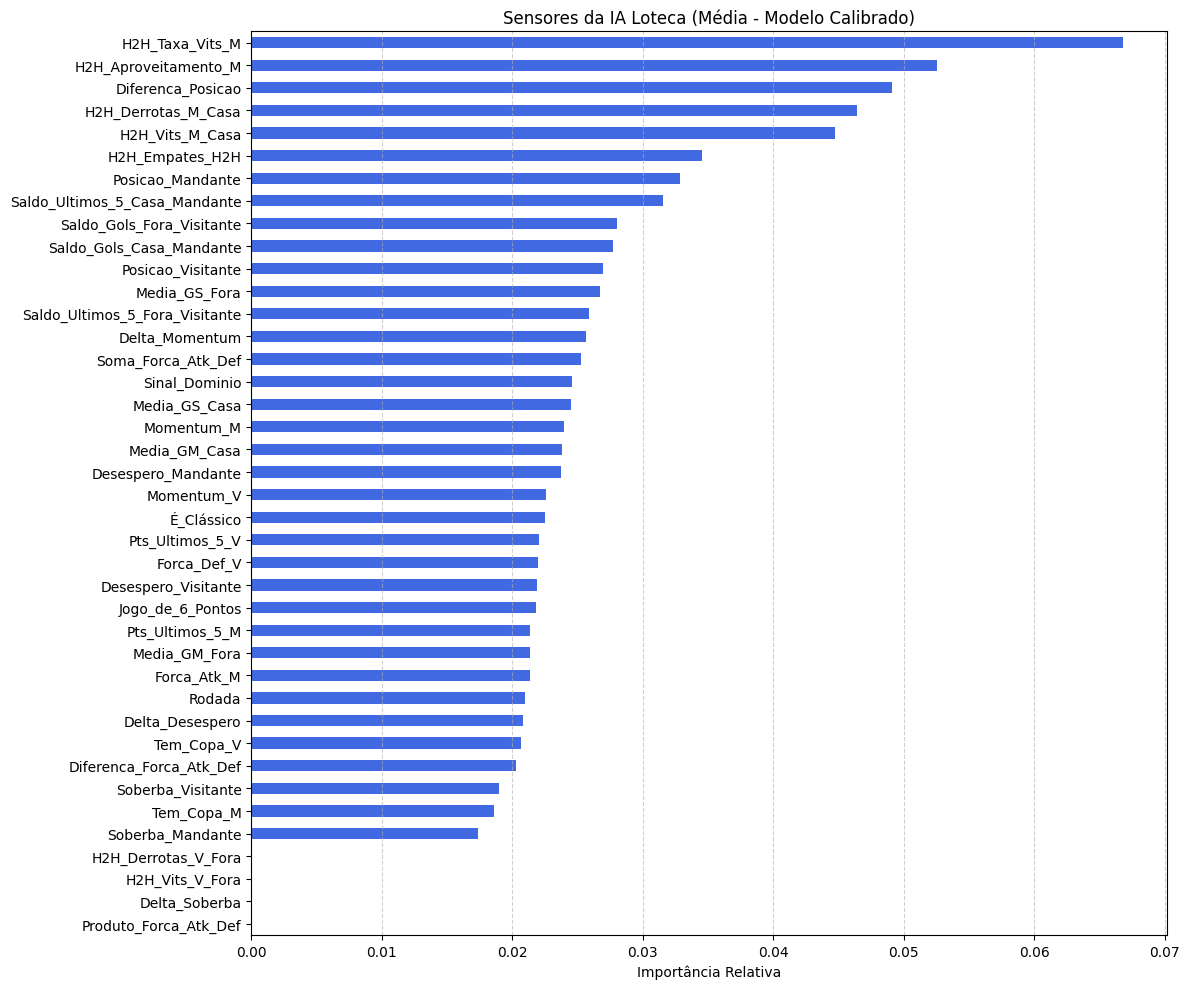

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Extrair e tirar a média das importâncias usando o novo atributo 'estimator'
importancias_medias = np.mean([
    est.estimator.feature_importances_ for est in modelo_loteca.calibrated_classifiers_
], axis=0)

# 2. Criar a Series com os nomes das colunas
importancias = pd.Series(importancias_medias, index=X.columns)

# 3. Plotar o gráfico com os 45 sensores mais influentes
plt.figure(figsize=(12, 10))
importancias.nlargest(45).sort_values(ascending=True).plot(kind='barh', color='royalblue')
plt.title("Sensores da IA Loteca (Média - Modelo Calibrado)")
plt.xlabel("Importância Relativa")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Testar IA Detalhada com 2 duplos e 1 Triplo


In [12]:
import glob
import os
import re
import pandas as pd
import numpy as np

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def converter_sequencia(seq):
    if seq == '-' or pd.isna(seq): return 0
    mapa_pts = {'V': 3, 'E': 1, 'D': 0}
    return sum(mapa_pts.get(resultado, 0) for resultado in seq)

def executar_simulacao_ia_smart_order(diretorio, df_gabarito, modelo_ia, threshold):
    arquivos = sorted(glob.glob(os.path.join(diretorio, 'rodada*.csv')), key=natural_sort_key)
    mapa_res = {1: "CASA  ", 0: "EMPATE", 2: "FORA  "}

    for caminho in arquivos:
        df_concurso = pd.read_csv(caminho)
        nome_arquivo = os.path.basename(caminho)
        jogos_analise = []

        # 1. COLETA DE DADOS (Sem ordenar ainda)
        for i, jogo in df_concurso.iterrows():
            m, v = jogo['Time da Casa'], jogo['Time Visitante']
            jr = df_gabarito[(df_gabarito['Time da Casa'] == m) & (df_gabarito['Time Visitante'] == v)]
            if jr.empty: continue
            
            real_num = 1 if jr['Gols_Mandante'].values[0] > jr['Gols_Visitante'].values[0] else (2 if jr['Gols_Visitante'].values[0] > jr['Gols_Mandante'].values[0] else 0)
            stats_m = df_gabarito[(df_gabarito['Time da Casa'] == m) | (df_gabarito['Time Visitante'] == m)].tail(1)
            stats_v = df_gabarito[(df_gabarito['Time da Casa'] == v) | (df_gabarito['Time Visitante'] == v)].tail(1)

            # (O input_ia deve conter todas as 24 features conforme o teu treino anterior)
            input_ia = pd.DataFrame([{
                'Rodada': jogo['Rodada'], 'Posicao_Mandante': stats_m['Posicao_Mandante'].values[0],
                'Posicao_Visitante': stats_v['Posicao_Visitante'].values[0],
                'Diferenca_Posicao': stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0],
                'Media_GM_Casa': stats_m['Media_GM_Casa'].values[0], 'Media_GS_Casa': stats_m['Media_GS_Casa'].values[0],
                'Media_GM_Fora': stats_v['Media_GM_Fora'].values[0], 'Media_GS_Fora': stats_v['Media_GS_Fora'].values[0],
                'Saldo_Gols_Casa_Mandante': stats_m['Saldo_Gols_Casa_Mandante'].values[0],
                'Saldo_Gols_Fora_Visitante': stats_v['Saldo_Gols_Fora_Visitante'].values[0],
                'Saldo_Ultimos_5_Casa_Mandante': stats_m['Saldo_Ultimos_5_Casa_Mandante'].values[0],
                'Saldo_Ultimos_5_Fora_Visitante': stats_v['Saldo_Ultimos_5_Fora_Visitante'].values[0],
                'Pts_Ultimos_5_M': converter_sequencia(stats_m['Sequencia_5_Mandante'].values[0]),
                'Pts_Ultimos_5_V': converter_sequencia(stats_v['Sequencia_5_Visitante'].values[0]),
                'Tem_Copa_M': 1 if stats_m['Proxima_Copa_Mandante'].values[0] != '-' else 0,
                'Tem_Copa_V': 1 if stats_v['Proxima_Copa_Visitante'].values[0] != '-' else 0,
                'É_Clássico': jogo['É_Clássico'] if 'É_Clássico' in jogo else 0,
                'Jogo_de_6_Pontos': 1 if abs(stats_m['Posicao_Mandante'].values[0] - stats_v['Posicao_Visitante'].values[0]) <= 4 else 0,
                'Forca_Atk_M': stats_m['Forca_Atk_M'].values[0], 'Forca_Def_V': stats_v['Forca_Def_V'].values[0],
                'Sinal_Dominio': stats_m['Sinal_Dominio'].values[0], 'Momentum_M': stats_m['Momentum_M'].values[0],
                'Momentum_V': stats_v['Momentum_V'].values[0], 'Delta_Momentum': stats_m['Momentum_M'].values[0] - stats_v['Momentum_V'].values[0],
                'Soma_Forca_Atk_Def': stats_m['Soma_Forca_Atk_Def'].values[0],
                'Produto_Forca_Atk_Def': stats_m['Produto_Forca_Atk_Def'].values[0],
                'Diferenca_Forca_Atk_Def': abs(stats_m['Forca_Atk_M'].values[0] - stats_v['Forca_Def_V'].values[0]),
                'Desespero_Mandante': stats_m['Desespero_Mandante'].values[0],
                'Desespero_Visitante': stats_v['Desespero_Visitante'].values[0],
                'Delta_Desespero': stats_m['Delta_Desespero'].values[0],
                'Soberba_Mandante': stats_m['Soberba_Mandante'].values[0],
                'Soberba_Visitante': stats_v['Soberba_Visitante'].values[0],
                'Delta_Soberba': stats_m['Delta_Soberba'].values[0],
                'H2H_Vits_M_Casa': stats_m['H2H_Vits_M_Casa'].values[0],
                'H2H_Derrotas_M_Casa': stats_m['H2H_Derrotas_M_Casa'].values[0],
                'H2H_Vits_V_Fora': stats_v['H2H_Vits_V_Fora'].values[0],
                'H2H_Derrotas_V_Fora': stats_v['H2H_Derrotas_V_Fora'].values[0],
                'H2H_Empates_H2H': stats_m['H2H_Empates_H2H'].values[0],
                'H2H_Taxa_Vits_M': stats_m['H2H_Taxa_Vits_M'].values[0],
                'H2H_Aproveitamento_M': stats_m['H2H_Aproveitamento_M'].values[0]
            }])

            # --- 🎲 CÁLCULO DAS PROBABILIDADES ---
            probs = modelo_ia.predict_proba(input_ia)[0]
            ordem = np.argsort(probs)[::-1] # Índices do maior para o menor
            
            p_casa = probs[1]
            p_empate = probs[0]
            p_fora = probs[2]

            # ====================================================================
            # 🛡️ FILTRO RESTAURADO: REGRA DO EMPATE (25%)
            # ====================================================================
            # Se a chance de empate for >= 25% OU a diferença Casa/Fora for < threshold
            if p_empate >= 0.3 or abs(p_casa - p_fora) < p_empate:
                p_primario = 0  # Prioridade 1: Empate
            else:
                p_primario = np.argmax(probs) # Caso contrário, vai na maior prob
            
            # Define o palpite secundário (o melhor entre os que sobraram)
            p_secundario = ordem[1] if ordem[0] == p_primario else ordem[0]
            # ====================================================================

            jogos_analise.append({
                'id_original': i, 
                'confronto': f"{m[:12]} x {v[:12]}", 'real': real_num, 
                'p1': p_primario, 'p2': p_secundario,
                'gap': abs(p_casa - p_fora), # Gap entre times para decidir Duplos/Triplos
                'probs': probs,
                'p_casa': p_casa, 'p_empate': p_empate, 'p_fora': p_fora,
                'tipo': 'S' 
            })

        # 2. ALOCAÇÃO INTELIGENTE DE RECURSOS
        # Ordenamos temporariamente para decidir onde gastar
        jogos_analise.sort(key=lambda x: x['gap'])
        
        for idx, j in enumerate(jogos_analise):
            if idx == 0: j['tipo'] = 'T' # O mais incerto de todos leva o TRIPLO
            elif idx < 3: j['tipo'] = 'D' # Os próximos 6 levam DUPLO

        # 3. VOLTA À ORDEM ORIGINAL E IMPRIME
        jogos_analise.sort(key=lambda x: x['id_original'])

        print(f"\n# {nome_arquivo.upper()} - BILHETE FINAL #")
        print(f"{'J':<2} | {'CONFRONTO':<32} | {'TIPO':<4} | {'CASA%':<6} | {'EMP%':<6} | {'FORA%':<6} | {'PALPITE':<18} | {'REAL':<8} | {'STATUS'}")        
        print("-" * 130)

        acertos = 0
        for idx, j in enumerate(jogos_analise):
            p_max = np.max(j['probs'])
            
            # Validação
            acertou = (j['tipo'] == "T") or (j['tipo'] == "D" and (j['p1'] == j['real'] or j['p2'] == j['real'])) or (j['tipo'] == "S" and j['p1'] == j['real'])
            if acertou: acertos += 1
            
            palpite_str = "TRIPLO" if j['tipo'] == "T" else (f"{mapa_res[j['p1']]} / {mapa_res[j['p2']]}" if j['tipo'] == "D" else mapa_res[j['p1']])
            status = "✅" if acertou else "❌"
            print(f"{idx+1:<2} | {j['confronto']:<32} | {j['tipo']:<4} | {j['p_casa']:>6.1%} | {j['p_empate']:>6.1%} | {j['p_fora']:>6.1%} | {palpite_str:<18} |{mapa_res[j['real']]:<8}| {status}")
            #print(f"{idx+1:<2} | {j['confronto']:<28} | {j['tipo']:<4} | {p_max:.1%} | {palpite_str:<18} | {mapa_res[j['real']]:<8} | {status}")

        print(f"\n📊 TOTAL: {acertos}/14")
        print(f"📈 ACURÁCIA: {acertos/14:.1%}")

In [13]:
# 1. LIGAS NACIONAIS
df_13_a = pd.read_csv('dados/brasileiraoA/brasileiraoA2022.csv')
df_13_b = pd.read_csv('dados/brasileiraoB/brasileiraoB2022.csv')
df_13_a['Eh_Serie_B'] = 0
df_13_b['Eh_Serie_B'] = 1

# 2. METADADOS DOS TIMES (Regiões)
df_times_13 = pd.read_csv('dados/times/times2022.csv')

# 3. COMPETIÇÕES DE MATA-MATA (As Copas)
try:
    df_cb_13 = pd.read_csv('dados/copadobrasil/copadobrasil2022.csv')
    df_lib_13 = pd.read_csv('dados/libertadores/libertadores2022.csv')
    df_sud_13 = pd.read_csv('dados/sudamericana/sudamericana2022.csv')
    
    # Unifica todas as copas em um "Calendário Master" para o motor de features
    df_copas_13 = pd.concat([df_cb_13, df_lib_13, df_sud_13], ignore_index=True)
except FileNotFoundError as e:
    print(f"⚠️ Aviso: Algum arquivo de copa não foi encontrado: {e.filename}")
    # Cria um DF vazio com as colunas necessárias para não quebrar a função
    df_copas_13 = pd.DataFrame(columns=['Data', 'Time da Casa', 'Time Visitante'])

# 4. GERAÇÃO DO GABARITO ENRIQUECIDO
# Nota: Certifique-se de que sua função 'gerar_features_completas' aceite o argumento das copas

df_gabarito_13 = pd.concat([
    gerar_features_completas(df_13_a, df_times_13, df_copas_13,memoria_h2h),
    gerar_features_completas(df_13_b, df_times_13, df_copas_13,memoria_h2h)
], ignore_index=True)

# 5. EXECUÇÃO DA SIMULAÇÃO
executar_simulacao_ia_smart_order(
    diretorio='simulacao/2022', 
    df_gabarito=df_gabarito_13, 
    modelo_ia=modelo_loteca, 
    threshold=0.00
)


--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série A finalizado.

--- Integrando Sinais: Momentum, Força e Desespero ---
✅ Sucesso! DF Série B finalizado.

# RODADA1.CSV - BILHETE FINAL #
J  | CONFRONTO                        | TIPO | CASA%  | EMP%   | FORA%  | PALPITE            | REAL     | STATUS
----------------------------------------------------------------------------------------------------------------------------------
1  | Brusque x Guarani                | S    |  68.7% |  20.5% |  10.8% | CASA               |CASA    | ✅
2  | Bahia x Cruzeiro                 | S    |  47.8% |  40.1% |  12.1% | EMPATE             |CASA    | ❌
3  | Fluminense x Santos              | S    |   1.7% |   7.3% |  90.9% | FORA               |EMPATE  | ❌
4  | Atlético-GO x Flamengo           | S    |   1.3% |  58.4% |  40.3% | EMPATE             |EMPATE  | ✅
5  | Palmeiras x Ceará                | S    |  84.3% |  10.2% |   5.4% | CASA               |FORA    | ❌
6  | Ponte Pr